# PYTHON 資料科學期末專題 (二)

[提示]

用Pandas讀入時有時需要注意encoding參數

1.1 引入 Pandas Profiling

1.2 需要注意異常值與缺失值的處理, 注意資料區間, 評估值區間差異過大的問題

1.3 資料的分類, 以期可以分別繪製比對圖形; 

[基本目標]

把 Netflix 的資訊分門別列出來


[進階目標]

畫出Heatmap 與 文字雲(找出最多人看的影片)

# 參考範例

同學可以參照範例執行, 有問題隨時提問

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-3.0.0-py2.py3-none-any.whl size=248502 sha256=a80dd3ec9cc1b194c1198c3414adc76aefa5bc8ab185427c3210ae44834ad8f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ca56w42/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


In [2]:
# 載入繪圖相關套件
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# 載入資料處理相關套件
from pandas_profiling import ProfileReport
import numpy as np 
import pandas as pd 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Python/Netflix')
os.listdir()

['PYTHON資料科學期末專題(二)_進階目標.ipynb', 'netflix_titles.csv']

In [26]:
#載入資料集
df = pd.read_csv("netflix_titles.csv")
#檢視資料的項目
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [7]:
#查看資料集
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


# 導入pandas-profiling

import pandas_profiling

生成的數據報告

data是需要生成報告的數據，DataFrame型別

pandas_profiling.ProfileReport(data)

導出報告

pfr = pandas_profiling.ProfileReport(data)
pfr.to_file('report.html')

In [8]:
#生成資料集的報告, 可以用來檢核可視化結果是否正確
report = ProfileReport(df)

In [12]:
report.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 資料清洗

先確認缺失值狀況

In [13]:
# 功能：計算axis=0上的不同觀察結果, 主要是 Non NA
df.nunique()

show_id         6234
type               2
title           6172
director        3301
cast            5469
country          554
date_added      1524
release_year      72
rating            14
duration         201
listed_in        461
description     6226
dtype: int64

In [14]:
#計算缺失值
df.isna().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

### 修正 "rating" 這個欄位上的缺失狀況

In [15]:
df['rating'].unique()

array(['TV-PG', 'TV-MA', 'TV-Y7-FV', 'TV-Y7', 'TV-14', 'R', 'TV-Y', 'NR',
       'PG-13', 'TV-G', 'PG', 'G', nan, 'UR', 'NC-17'], dtype=object)

In [16]:
df['rating'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
6229    False
6230    False
6231     True
6232    False
6233    False
Name: rating, Length: 6234, dtype: bool

In [18]:
df[df['rating'].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
211,70129452,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
2411,80144119,Movie,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."
3288,80169801,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
4056,80078037,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
4402,80092839,Movie,Fireplace 4K: Classic Crackling Fireplace from...,George Ford,NaN,NaN,"December 21, 2015",2015,NaN,60 min,Movies,"The first of its kind in UHD 4K, with the clea..."
4403,80092835,Movie,Fireplace 4K: Crackling Birchwood from Firepla...,George Ford,NaN,NaN,"December 21, 2015",2015,NaN,60 min,Movies,"For the first time in 4K Ultra-HD, everyone's ..."
4706,80039789,TV Show,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
5015,80114111,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...
5234,80161109,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...


# 基於 Netflix shows,我們可以嘗試使用 replacements

In [21]:
rating_replacements = {
    211: 'TV-14',
    2411: 'TV-14',
    3288: 'PG-13',
    4056: 'TV-G',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-14',
    5234: 'TV-14',
    6231: 'TV-Y'
}

for id, rate in rating_replacements.items():
    df.iloc[id, 8] = rate
    
df['rating'].isna().sum()

0

### 為了簡單處理, 先行丟棄director 跟 cast

cast: 太多異常值, 因為太多演員

In [28]:
df = df.drop(['director', 'cast'], axis=1)
df.columns

Index(['show_id', 'type', 'title', 'country', 'date_added', 'release_year',
       'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

### 修正date_added 缺失狀況 

In [29]:
df[df['date_added'].isna()]

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description
6223,70204989,TV Show,Gunslinger Girl,Japan,NaN,2008,TV-14,2 Seasons,"Anime Series, Crime TV Shows","On the surface, the Social Welfare Agency appe..."
6224,70304979,TV Show,Anthony Bourdain: Parts Unknown,United States,NaN,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...
6225,70153412,TV Show,Frasier,United States,NaN,2003,TV-PG,11 Seasons,"Classic & Cult TV, TV Comedies",Frasier Crane is a snooty but lovable Seattle ...
6226,70243132,TV Show,La Familia P. Luche,United States,NaN,2012,TV-14,3 Seasons,"International TV Shows, Spanish-Language TV Sh...","This irreverent sitcom featues Ludovico, Feder..."
6227,80005756,TV Show,The Adventures of Figaro Pho,Australia,NaN,2015,TV-Y7,2 Seasons,"Kids' TV, TV Comedies","Imagine your worst fears, then multiply them: ..."
6228,80159925,TV Show,Kikoriki,NaN,NaN,2010,TV-Y,2 Seasons,Kids' TV,A wacky rabbit and his gang of animal pals hav...
6229,80000063,TV Show,Red vs. Blue,United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


I have search for them in the internet and is dificult to find the `date_added`to Netlix, so i will drop them, as they are only 11 rows

In [30]:
df = df[df['date_added'].notna()]

### 修正country 類別的狀況

In [31]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

### 確認缺失值的處理是否完整

In [32]:
df.isna().sum()

show_id         0
type            0
title           0
country         0
date_added      0
release_year    0
rating          9
duration        0
listed_in       0
description     0
dtype: int64

## 產生新的特徵

In [33]:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


### 利用日期相加取得新的年月資料

我們將從date_add中獲取年份和月份，以便我們可以比較最有價值的月份在Show realse與Netflix我們新增日期的部分

In [42]:
df['year_added'] = df['date_added'].apply(lambda x: x.split(" ")[-1])
df['year_added'].head()

0    2019
1    2016
2    2018
3    2018
4    2017
Name: year_added, dtype: object

In [40]:
df['month_added'] = df['date_added'].apply(lambda x: x.split(" ")[0])
df['month_added'].head()

0    September
1    September
2    September
3    September
4    September
Name: month_added, dtype: object

In [ ]:
### 根據評分顯示目標

這可能很有趣，表明目標主要是productions

In [44]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

In [45]:
df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

array(['Older Kids', 'Adults', 'Teens', 'Kids', nan], dtype=object)

### Country 

在某些條目中，國家具有多個值。所以將在第一列中添加一個新列，以便我們檢查witch區域是否有更多作品

In [48]:
# Lets retrieve just the first country
df['principal_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['principal_country'].head()

0     United States
1    United Kingdom
2     United States
3     United States
4     United States
Name: principal_country, dtype: object

## 修正日期型別

In [49]:
df.dtypes

show_id               int64
type                 object
title                object
country              object
date_added           object
release_year          int64
rating               object
duration             object
listed_in            object
description          object
year_added           object
month_added          object
target_ages          object
principal_country    object
dtype: object

In [50]:
# type should be a category
df['type'] = pd.Categorical(df['type'])
# target_ages is another category (4 classes)
df['target_ages'] = pd.Categorical(df['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

# Year added should be integer so we can compare with `released_year`
df['year_added'] = pd.to_numeric(df['year_added'])

In [51]:
df.dtypes

show_id                 int64
type                 category
title                  object
country                object
date_added             object
release_year            int64
rating                 object
duration               object
listed_in              object
description            object
year_added              int64
month_added            object
target_ages          category
principal_country      object
dtype: object

# 資料視覺化

In [52]:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,target_ages,principal_country
0,81145628,Movie,Norm of the North: King Sized Adventure,"United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019,September,Older Kids,United States
1,80117401,Movie,Jandino: Whatever it Takes,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016,September,Adults,United Kingdom
2,70234439,TV Show,Transformers Prime,United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018,September,Older Kids,United States
3,80058654,TV Show,Transformers: Robots in Disguise,United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018,September,Older Kids,United States
4,80125979,Movie,#realityhigh,United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017,September,Teens,United States


In [59]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
df['genre'].head()

0    [Children & Family Movies, Comedies]
1                       [Stand-Up Comedy]
2                              [Kids' TV]
3                              [Kids' TV]
4                              [Comedies]
Name: genre, dtype: object

In [60]:
movie_df = df[df['type'] == 'Movie']
show_df = df[df['type'] == 'TV Show']

show_df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,target_ages,principal_country,genre
2,70234439,TV Show,Transformers Prime,United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018,September,Older Kids,United States,[Kids' TV]
3,80058654,TV Show,Transformers: Robots in Disguise,United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018,September,Older Kids,United States,[Kids' TV]
5,80163890,TV Show,Apaches,Spain,"September 8, 2017",2016,TV-MA,1 Season,"Crime TV Shows, International TV Shows, Spanis...",A young journalist is forced into a life of cr...,2017,September,Adults,Spain,"[Crime TV Shows, International TV Shows, Spani..."
8,80117902,TV Show,Fire Chasers,United States,"September 8, 2017",2017,TV-MA,1 Season,"Docuseries, Science & Nature TV","As California's 2016 fire season rages, brave ...",2017,September,Adults,United States,"[Docuseries, Science & Nature TV]"
26,80244601,TV Show,Castle of Stars,United States,"September 7, 2018",2015,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...",As four couples with different lifestyles go t...,2018,September,Teens,United States,"[International TV Shows, Romantic TV Shows, TV..."


# TV shows 跟 Movies的比例

In [73]:
df['type'].value_counts().reset_index()

,index,type
0,Movie,4264
1,TV Show,1959


In [74]:
fig = px.pie(df['type'].value_counts().reset_index(), values='type', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [93]:
#新增rating 的資料子集
#方便做年齡層的分布查詢
def generate_rating_df(df):
    rating_df = df.groupby(['rating', 'target_ages']).agg({'show_id': 'count'}).reset_index()
    rating_df = rating_df[rating_df['show_id'] != 0]
    rating_df.columns = ['rating', 'target_ages', 'counts'] # 替換column
    rating_df = rating_df.sort_values('target_ages')
    return rating_df

In [95]:
df.groupby(['rating', 'target_ages']).agg({'show_id': 'count'}).reset_index().head(20)

,rating,target_ages,show_id
0,G,Kids,37
1,G,Older Kids,0
2,G,Teens,0
3,G,Adults,0
4,NC-17,Kids,0
5,NC-17,Older Kids,0
6,NC-17,Teens,0
7,NC-17,Adults,2
8,NR,Kids,0
9,NR,Older Kids,0


In [97]:
rating_df = generate_rating_df(df)
fig = px.bar(rating_df, x='rating', y='counts', color='target_ages')
fig.show()

In [108]:
#針對影集或是歌劇
movie_rating_df = generate_rating_df(movie_df)
show_rating_df = generate_rating_df(show_df)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(labels=movie_rating_df['target_ages'], values=movie_rating_df['counts']),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=show_rating_df['target_ages'], values=show_rating_df['counts']),
    row=1, col=2
)

fig.update_traces(textposition='inside', hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Rating distribution by Type of content",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Movies', x=0.21, y=0.5, font_size=12, showarrow=False),
                 dict(text='TV Shows', x=0.80, y=0.5, font_size=12, showarrow=False)])
fig.show()

In [109]:
#按國別分別顯示影集與歌劇的產出分布,使用圓餅圖
country_df = df['principal_country'].value_counts().reset_index()
country_df = country_df[country_df['principal_country'] /  country_df['principal_country'].sum() > 0.01]

fig = px.pie(country_df, values='principal_country', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [115]:
#按國別分別顯示影集與歌劇的產出分布,使用歷史分布
fig = px.histogram(df, x='principal_country')
fig.update_xaxes(categoryorder='total descending')
fig.show()

## 發佈內容
我們可以看到，在過去的幾年中，內容製作的數量在增加

In [118]:
released_year_df = df.loc[df['release_year'] > 2010].groupby(['release_year', 'type']).agg({'show_id': 'count'}).reset_index()
added_year_df = df.loc[df['year_added'] > 2010].groupby(['year_added', 'type']).agg({'show_id': 'count'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'Movie']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Released Year',
    marker_color='green',
))
fig.add_trace(go.Scatter( 
    x=released_year_df.loc[released_year_df['type'] == 'TV Show']['release_year'], 
    y=released_year_df.loc[released_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Released Year',
    marker_color='darkgreen',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'Movie']['year_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'Movie']['show_id'],
    mode='lines+markers',
    name='Movie: Year Added',
    marker_color='orange',
))
fig.add_trace(go.Scatter( 
    x=added_year_df.loc[added_year_df['type'] == 'TV Show']['year_added'], 
    y=added_year_df.loc[added_year_df['type'] == 'TV Show']['show_id'],
    mode='lines+markers',
    name='TV Show: Year Added',
    marker_color='darkorange',
))
#fig.update_xaxes(categoryorder='total descending')
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



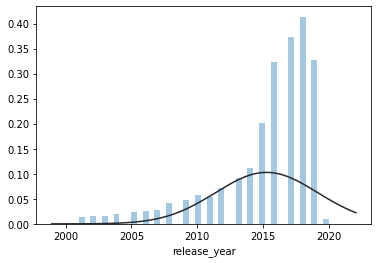

In [127]:
from scipy.stats import norm

sns.distplot(df.loc[df['release_year'] > 2000, 'release_year'], fit=norm, kde=False)

#displot()集合了matplotlib的hist()與核函數估計kdeplot的功能，
#增加了rugplot分佈觀測條顯示與利用scipy庫fit擬合參數分佈的新穎用途。
#fit：控制擬合的參數分佈圖形，能夠直觀地評估它與觀察數據的對應關係(黑色線條為確定的分佈)

## 建立內容類型的數據框

In [129]:
#導入SKLEARN的前處理套件, 將元素進行二元變換 , 輸入的資料會轉換成一個 一維 classes_
#每組資料會轉換成和 classes_ 相同大小的一維陣列
#如果資料有對應到 classes_  就為 1 否則為 0

from sklearn.preprocessing import MultiLabelBinarizer 

In [140]:
def calculate_mlb(series):
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    
    return mlb_df

In [142]:
calculate_mlb(df['genre']).head()

,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,Documentaries,Docuseries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,International TV Shows,Kids' TV,Korean TV Shows,LGBTQ Movies,Movies,Music & Musicals,Reality TV,Romantic Movies,Romantic TV Shows,Sci-Fi & Fantasy,Science & Nature TV,Spanish-Language TV Shows,Sports Movies,Stand-Up Comedy,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
calculate_mlb(df['genre']).sum().head()

Action & Adventure          597
Anime Features               45
Anime Series                116
British TV Shows            209
Children & Family Movies    378
dtype: int64

In [137]:
#如何在csv文件中將一列拆分為單獨的列
def top_genres(df, title='Top ones'):
    genres_df = calculate_mlb(df['genre'])
    tdata = genres_df.sum().sort_values(ascending=False) # sum: axis=0

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=tdata.index,
        y=tdata.values,
    ))
    fig.update_xaxes(categoryorder='total descending')
    fig.update_layout(title=title)
    fig.show()

In [138]:
top_genres(movie_df, title='Top Movies Genres')

In [146]:
top_genres(show_df, title='Top TV Shows Genres')

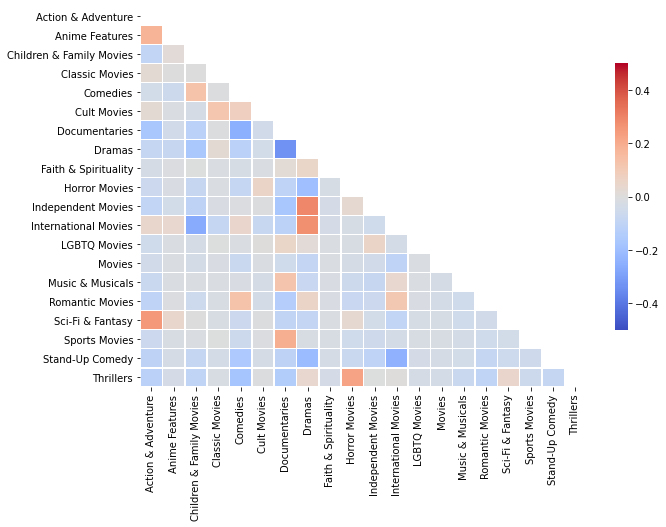

In [165]:
#如何在csv文件中將一列拆分為單獨的列
genres_df = calculate_mlb(movie_df['genre'])

movie_corr = genres_df.corr()
movie_mask = np.zeros_like(movie_corr, dtype=np.bool)
movie_mask[np.triu_indices_from(movie_mask)] = True
# triu_indices_from: Return the indices for the upper-triangle of arr.
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(movie_corr, mask=movie_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.7})
plt.show()

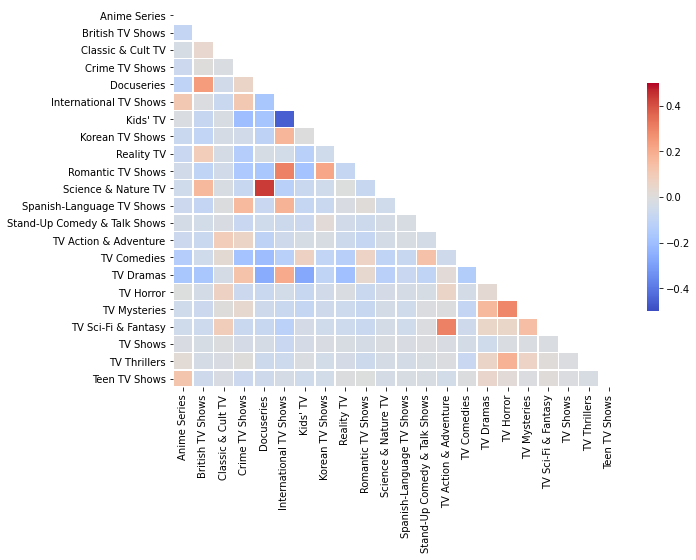

In [166]:
genres_df = calculate_mlb(show_df['genre'])

show_corr = genres_df.corr()
show_mask = np.zeros_like(show_corr, dtype=np.bool)
show_mask[np.triu_indices_from(show_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(show_corr, mask=show_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

In [167]:
#載入文字雲套件
!pip install wordcloud

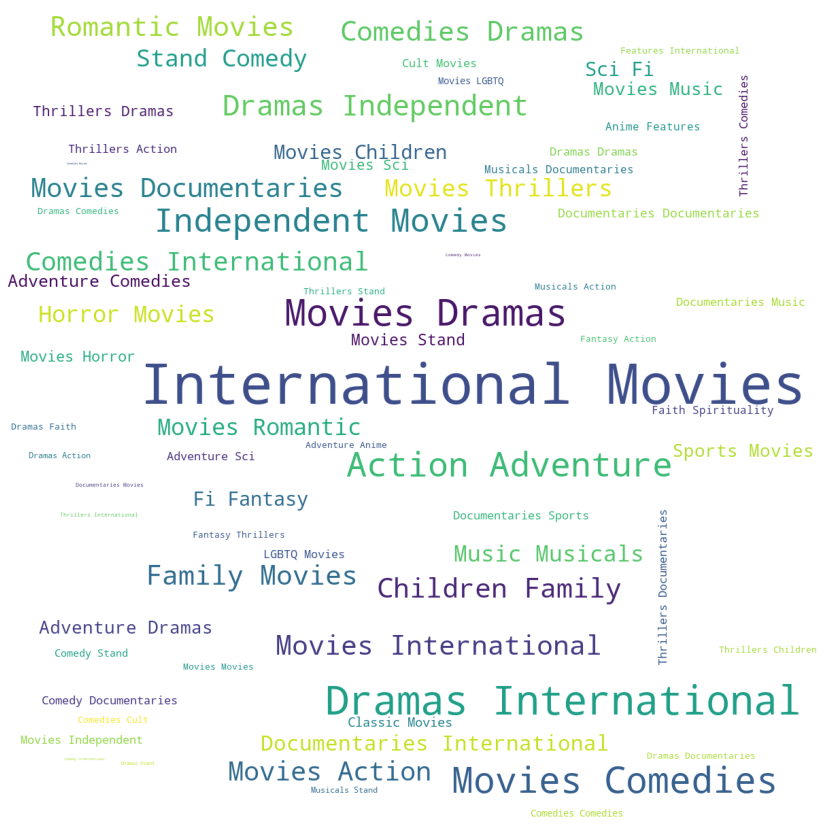

In [177]:
#使用文字雲, 找出最多被使用在資料集上的描述
#對文本數據中出現頻率較高的“關鍵詞”在視覺上的突出呈現，形成關鍵詞的渲染形成類似雲一樣的彩色圖片，從而一眼就可以領略文本數據的主要表達意思
from wordcloud import WordCloud

text = str(list(movie_df['genre'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '')

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 分析TV SHOW系列持續時間

In [183]:
fig = px.histogram(x=show_df['duration'])
fig.update_xaxes(categoryorder="total ascending")
fig.update_layout(
    title="Distribution of shows duration",
    xaxis_title="Duration of the Shows",
)
fig.show()

### 分析MOVIE系列持續時間

In [182]:
fig = px.histogram(x=movie_df['duration'])
fig.update_xaxes(categoryorder="total ascending")
fig.update_layout(
    title="Distribution of movies duration",
    xaxis_title="Duration of the Movies",
)
fig.show()